In [1]:
%matplotlib inline
from __future__ import print_function
from matplotlib import pyplot as plt
import collections
import os, struct
import numpy as np
import scipy as sp
import math
import random
from random import randint
import string
import tensorflow as tf
import gzip
import zlib
import tarfile
import pandas as pd
from six.moves import range
from six.moves.urllib.request import urlretrieve
from array import array as pyarray 
from six.moves import cPickle as pickle
from scipy.misc import imresize
import skimage
from skimage import data
from skimage import exposure
from skimage import img_as_ubyte
from skimage.transform import resize
from skimage.transform import rescale
from skimage.transform import rotate
from skimage import novice

In [ ]:
def maybe_download(base_url, dest_folder, filename, expected_bytes=None):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    filepath = os.path.join(dest_folder,filename)
    if not os.path.exists(filepath):
        filepath, _ = urlretrieve(base_url + filename, filepath)
    statinfo = os.stat(filepath)
    if expected_bytes is None or statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

In [3]:
def maybe_untargz(filename, dest_folder,force=False):
    extraction_dir = filename.split(".")[0]
    if not os.path.isdir(extraction_dir):
        tar = tarfile.open(filename, "r:gz")
        tar.extractall(dest_folder)
        tar.close()
        print (filename + " extracted to " + extraction_dir)
    else:
        print ("Folder " + extraction_dir + " already exists. Skipping")

In [4]:
def saveAsPickle(data,filename):
    try:
        with open(filename, 'wb') as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
            print (filename + " pickled!")
    except Exception as e:
        print('Unable to save data to', filename, ':', e)
        
def loadPickle(file):
    with open(file, 'rb') as pickle_file:
        return pickle.load(pickle_file)

## MNIST Dataset ##
Let's download and uncompress the MNIST dataset

In [5]:
mnist_base_url = 'http://yann.lecun.com/exdb/mnist/'
mnist_dest_folder = 'data/mnist/'

train_images = maybe_download(mnist_base_url, mnist_dest_folder, 'train-images-idx3-ubyte.gz', 9912422)
train_labels = maybe_download(mnist_base_url, mnist_dest_folder, 'train-labels-idx1-ubyte.gz', 28881)
test_images = maybe_download(mnist_base_url, mnist_dest_folder, 't10k-images-idx3-ubyte.gz', 1648877)
test_labels = maybe_download(mnist_base_url, mnist_dest_folder, 't10k-labels-idx1-ubyte.gz', 4542)

files = [train_images,train_labels]

for file in files:
    filepath = os.path.join(mnist_dest_folder,file)
    inF = gzip.open(filepath, 'rb')
    outF = open(filepath.split(".",2)[0], 'wb')
    outF.write( inF.read() )
    inF.close()
    outF.close()

Found and verified train-images-idx3-ubyte.gz
Found and verified train-labels-idx1-ubyte.gz
Found and verified t10k-images-idx3-ubyte.gz
Found and verified t10k-labels-idx1-ubyte.gz


We want to generate a simple synthetic dataset with exactly the same street numbers as the SVHN dataset. Each number will be made of digits randomly picked from the MNIST dataset. 

First, let's create one pickle archive for each digit values. The archive for digit 0 will contain all MNIST instances (28x28 arrays) of 0.


In [6]:
def load_mnist(dataset="training", digits=None, path="", asbytes=False, selection=None, return_labels=True, return_indices=False):
    """
    from: https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py
    Loads MNIST files into a 3D numpy array.

    Parameters
    ----------
    dataset : str 
        Either "training" or "testing", depending on which dataset you want to
        load. 
    digits : list 
        Integer list of digits to load. The entire database is loaded if set to
        ``None``. Default is ``None``.
    path : str 
        Path to your MNIST datafiles. The default is ``None``, which will try
        to take the path from your environment variable ``MNIST``. The data can
        be downloaded from http://yann.lecun.com/exdb/mnist/.
    asbytes : bool
        If True, returns data as ``numpy.uint8`` in [0, 255] as opposed to
        ``numpy.float64`` in [0.0, 1.0].
    selection : slice
        Using a `slice` object, specify what subset of the dataset to load. An
        example is ``slice(0, 20, 2)``, which would load every other digit
        until--but not including--the twentieth.
    return_labels : bool
        Specify whether or not labels should be returned. This is also a speed
        performance if digits are not specified, since then the labels file
        does not need to be read at all.
    return_indicies : bool
        Specify whether or not to return the MNIST indices that were fetched.
        This is valuable only if digits is specified, because in that case it
        can be valuable to know how far
        in the database it reached.

    Returns
    -------
    images : ndarray
        Image data of shape ``(N, rows, cols)``, where ``N`` is the number of images. If neither labels nor inices are returned, then this is returned directly, and not inside a 1-sized tuple.
    labels : ndarray
        Array of size ``N`` describing the labels. Returned only if ``return_labels`` is `True`, which is default.
    indices : ndarray
        The indices in the database that were returned.
    """

    # The files are assumed to have these names and should be found in 'path'
    files = {
        'training': ('train-images-idx3-ubyte', 'train-labels-idx1-ubyte'),
        'testing': ('t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte'),
    }

    try:
        images_fname = os.path.join(path, files[dataset][0])
        labels_fname = os.path.join(path, files[dataset][1])
    except KeyError:
        raise ValueError("Data set must be 'testing' or 'training'")

    # We can skip the labels file only if digits aren't specified and labels aren't asked for
    if return_labels or digits is not None:
        flbl = open(labels_fname, 'rb')
        magic_nr, size = struct.unpack(">II", flbl.read(8))
        labels_raw = pyarray("b", flbl.read())
        flbl.close()

    fimg = open(images_fname, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    images_raw = pyarray("B", fimg.read())
    fimg.close()

    if digits:
        indices = [k for k in range(size) if labels_raw[k] in digits]
    else:
        indices = range(size)

    if selection:
        indices = indices[selection] 
    N = len(indices)

    images = np.zeros((N, rows, cols), dtype=np.uint8)

    if return_labels:
        labels = np.zeros((N), dtype=np.int8)
    for i, index in enumerate(indices):
        images[i] = np.array(images_raw[ indices[i]*rows*cols : (indices[i]+1)*rows*cols ]).reshape((rows, cols))
        if return_labels:
            labels[i] = labels_raw[indices[i]]

    if not asbytes:
        images = images.astype(float)/255.0

    ret = (images,)
    if return_labels:
        ret += (labels,)
    if return_indices:
        ret += (indices,)
    if len(ret) == 1:
        return ret[0] # Don't return a tuple of one
    else:
        return ret
    
    
training_data_digits = list()
for i in range(10):
    l = list()
    l.append(i)
    d = load_mnist(dataset="training", digits=l, path=mnist_dest_folder, asbytes=False, 
                   selection=None, return_labels= True, return_indices=False)
    saveAsPickle(d,os.path.join(mnist_dest_folder,"mnist_training_digit_"+str(i)+".pickle"))
    training_data_digits.append(d)
    

data/mnist/mnist_training_digit_0.pickle pickled!
data/mnist/mnist_training_digit_1.pickle pickled!
data/mnist/mnist_training_digit_2.pickle pickled!
data/mnist/mnist_training_digit_3.pickle pickled!
data/mnist/mnist_training_digit_4.pickle pickled!
data/mnist/mnist_training_digit_5.pickle pickled!
data/mnist/mnist_training_digit_6.pickle pickled!
data/mnist/mnist_training_digit_7.pickle pickled!
data/mnist/mnist_training_digit_8.pickle pickled!
data/mnist/mnist_training_digit_9.pickle pickled!


Let's look at a sample of our digits and make sure they have correct labels

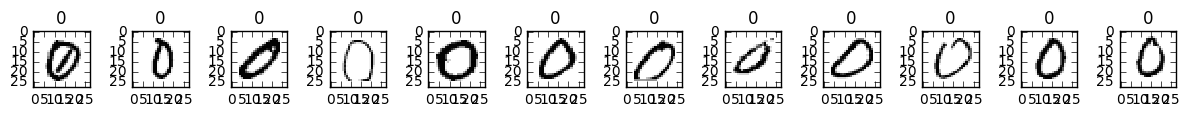

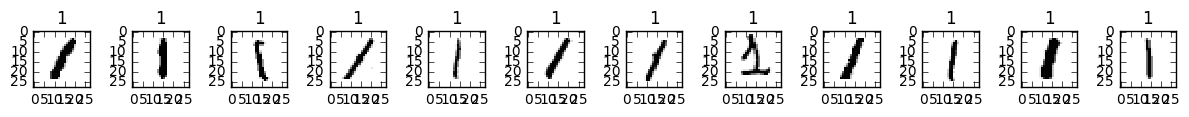

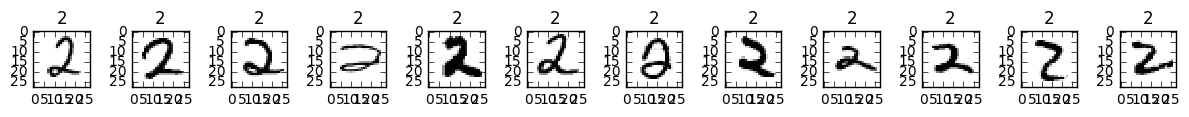

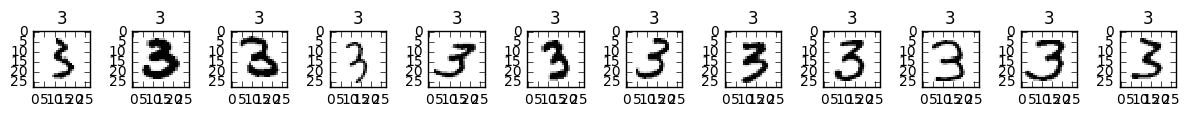

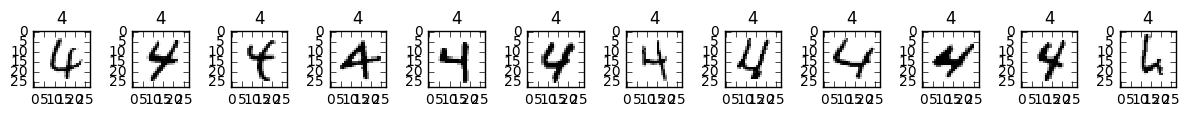

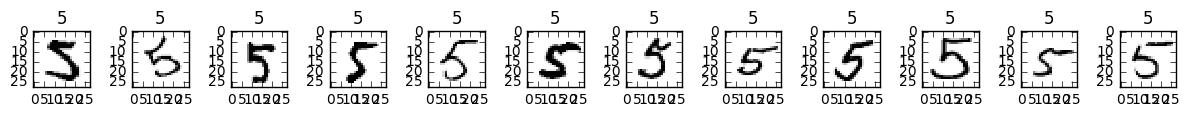

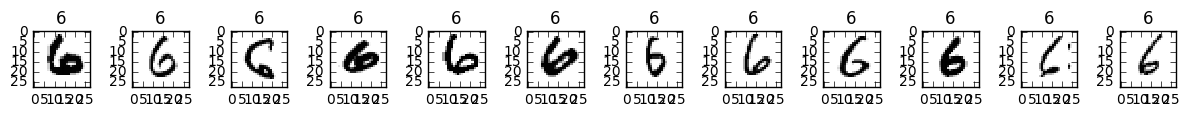

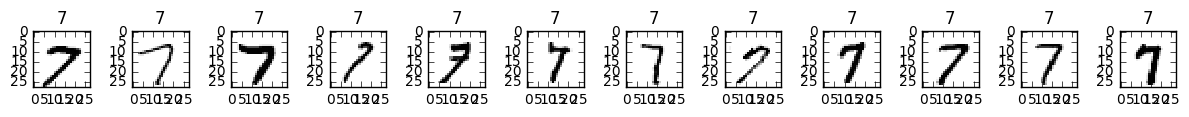

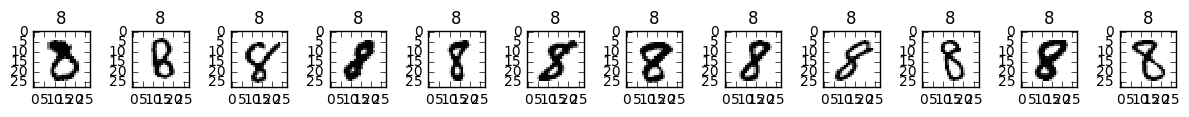

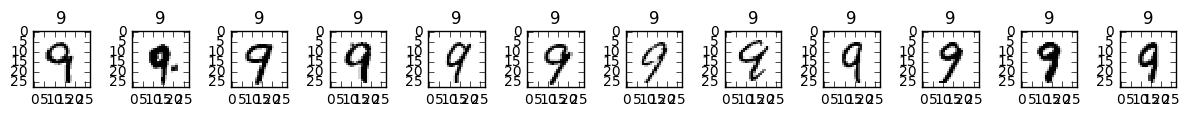

In [7]:
def sanity_check(data):
    """
    Prints digits as image along with their labels
    """
    img_labels = data[1]
    img_data =(data[0]*255).astype(int)
    indices = np.random.randint(img_data.shape[0]-1,size=12)
    fig = plt.figure(figsize=(12, 3), dpi=80)
    for index,indice in enumerate(indices):
        plt.subplot(1,12,index+1)
        plt.title(img_labels[indice])
        plt.imshow(img_data[indice], interpolation='nearest',cmap='Greys')
        plt.tight_layout()
    plt.show()
    
for i in range(0,10):    
    da = pickle.load( open(os.path.join(mnist_dest_folder,"mnist_training_digit_"+str(i)+".pickle"), "rb" ))
    sanity_check(da)

## Dataset generation ##

Let's load MNIST digits and the SVHN meta data and create our validation set

In [11]:
digits_data = list(pickle.load( open(os.path.join(mnist_dest_folder,"mnist_training_digit_"+str(i)+".pickle"), "rb" )) for i in range(10))
train_df = loadPickle(os.path.join(svhn_dest_folder,"train","digitStruct_nozeros.dataframe"))
test_df = loadPickle(os.path.join(svhn_dest_folder,"test","digitStruct_nozeros.dataframe"))

train_df = train_df.reindex(np.random.permutation(train_df.index)).reset_index(drop=True)
split = int(train_df.shape[0] * 0.9)
valid_df = train_df[split:].reset_index(drop=True)
train_df = train_df[:split]

print ("Training set size: %d" % train_df.shape[0])
print ("Validation set size: %d" % valid_df.shape[0])
print ("Test set size: %d" % test_df.shape[0])

Training set size: 30010
Validation set size: 3335
Test set size: 13054


Now our synthetic dataframe containing exactly the same values (street numbers) as the SVHN is composed as follows:
 

The file `data/synth_svhn_64x64_[train|test].pickle` (`ndarray`) contains a tuple with:
- street number value (ex.: '123')
- street number digits (ex.: '[1,2,3,0,0,0]')
- image data: [64 x 64] array

    

In [12]:
def get_mnist_digit(digit):
    '''
    Get a random digit array from a digit value
    '''
    return digits_data[digit][0][np.random.randint(digits_data[digit][0].shape[0])]

def generate_data(numbers, scale=1,max_length=6, dims=(64,64), noise=0.0):
    """
    Generate dataset based on svh numbers. Return a tuple with
    - 64 x 64 images
    - digits
    - street number values
    - lengths
    """
    img_data = np.zeros((len(numbers), dims[0], dims[1], 1))
    values = np.zeros(len(numbers)).astype(int)
    digits = np.zeros((len(numbers),6)).astype(int)
    lengths = np.zeros((len(numbers),)).astype(int)
    
    for i, number in enumerate(numbers):
        values[i] = int(number)
        
        # numbers as lists of digits (ex: 345 -> [3,4,5])
        number_digits = [int(j) for j in list(str(values[i]))]
        lengths[i] = min(len(number_digits),6)
        digits[i,0:lengths[i]] = number_digits[:lengths[i]]  
        # labels must be classes, not values.
        # Our classes for lengths [1,2,3,4,5,6] are [0,1,2,3,4,5]
        lengths[i] -= 1 
        
        # Generate an image with the sequence of digits
        number_image = np.zeros((28,28*len(number_digits)))
        for k,digit in enumerate(number_digits):
            number_image[0:28, k*28:(k+1)*28] = get_mnist_digit(digit)

        scale = float(dims[0]) / ((lengths[i]+1) * 28)
        if scale != 1:
            number_image = imresize(number_image,scale,interp='bilinear')
        # Place it randomly in the canvas
        max_top = dims[0] - number_image.shape[0] 
        max_left = dims[1] - number_image.shape[1]      
        
        top = np.random.randint(0,max_top) if max_top > 0 else 0
        left = np.random.randint(0,max_left) if max_left > 0 else 0
        
        img_data[i,top:top+number_image.shape[0],left:left+number_image.shape[1],0] = number_image
        
        # Add noise
        if noise > 0:
            img_data[i] = skimage.util.random_noise(img_data[i], mode='gaussian', mean=noise)
        
    return (img_data, digits, values, lengths)


def dataset_sample(data):
    """
    Prints numbers as image along with their labels
    """
    labels = data[2]
    img_data = data[0].reshape(data[0].shape[0],data[0].shape[1],data[0].shape[2])
    fig = plt.figure(figsize=(12,8), dpi=80)
    for index,image in enumerate(img_data[:36]):
        plt.subplot(6, 6, index+1)
        plt.title(str(labels[index]) + " : " + str(data[1][index]) + str(data[3][index]))
        plt.imshow(image, cmap='Greys')
        plt.tight_layout()
    plt.show()
    
def generate_and_save_dataset(name,train_data,valid_data,test_data):
    saveAsPickle(train_data, os.path.join("data",str("train_%s.pickle" % name)))
    saveAsPickle(valid_data, os.path.join("data",str("valid_%s.pickle" % name)))
    saveAsPickle(test_data, os.path.join("data",str("test_%s.pickle" % name)))

    print ("\nTrain")
    dataset_sample(train_data)
    print ("Valid")
    dataset_sample(valid_data)
    print ("Test")
    dataset_sample(test_data)
    return train_data, valid_data, test_data


We finally generate our dataset and save it to the disk. Note that we didn't save it as `tf.records`. The dataset is easy keep in memory and dealing with numpy arrays will simplify the model development.

data/train_synth_64x64.pickle pickled!
data/valid_synth_64x64.pickle pickled!
data/test_synth_64x64.pickle pickled!

Train


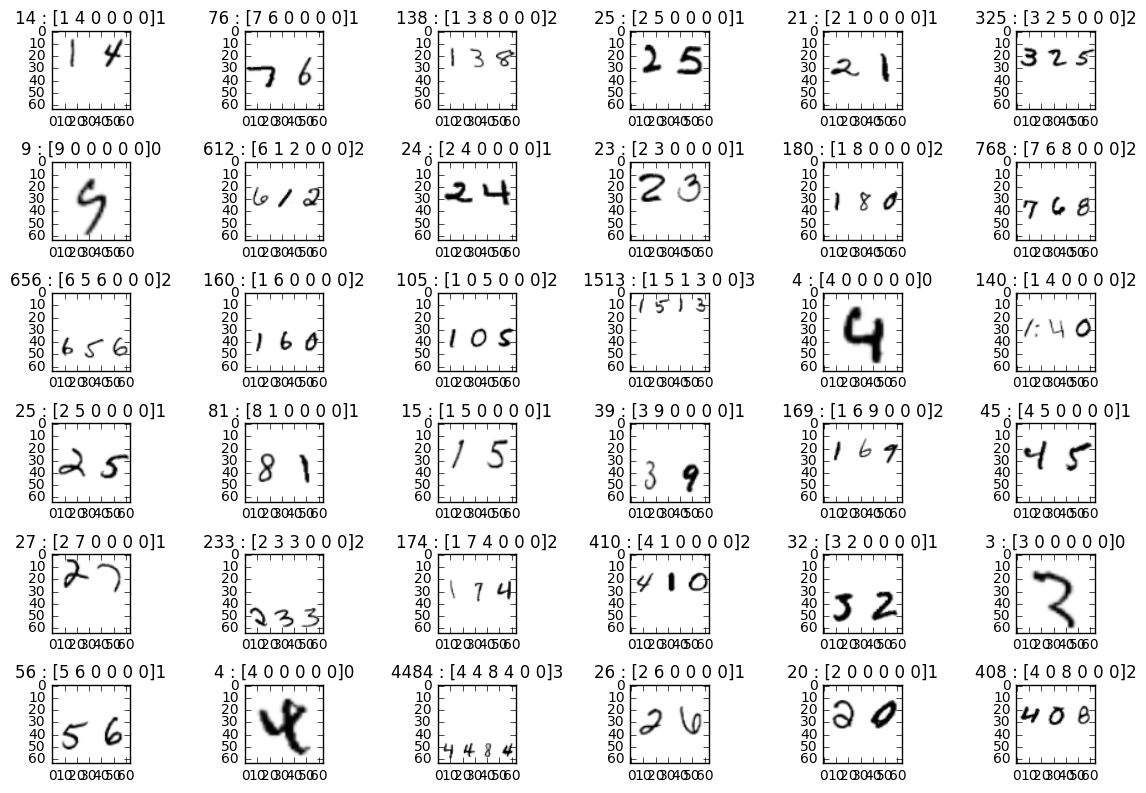

Valid


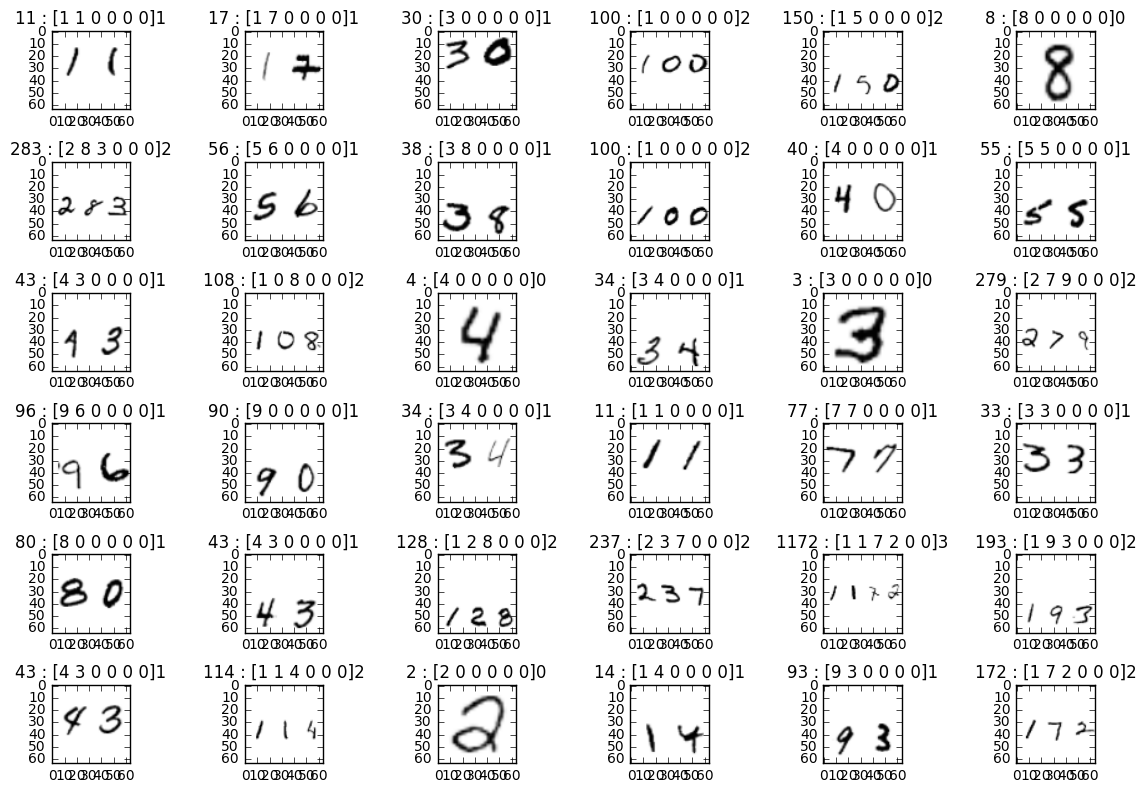

Test


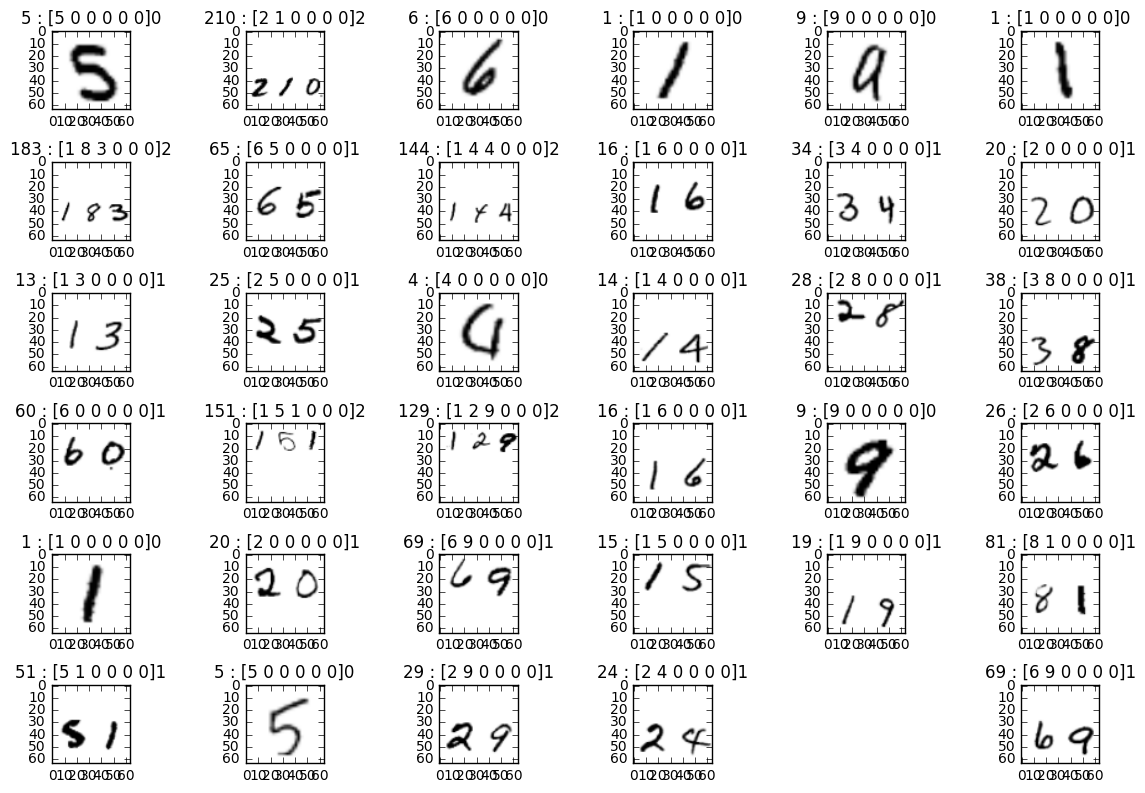

In [13]:
train_numbers = train_df['value'].tolist()
test_numbers = test_df['value'].tolist()
valid_numbers = valid_df['value'].tolist()
train,valid,test = generate_and_save_dataset("synth_64x64", 
                              generate_data(train_numbers), 
                              generate_data(valid_numbers), 
                              generate_data(test_numbers))
